# Titre

In [1]:
import torch
import random
import matplotlib.pyplot as plt
# from accelerate.test_utils.testing import get_backend
from transformers import AutoTokenizer, AutoModelForCausalLM

## Code setup

### Model loading

In [2]:
# Model list (all tested)
# gpt2
# gpt2-large
# EleutherAI/gpt-j-6B
# EleutherAI/gpt-neox-20b

MODEL_NAME = "gpt2-large" 

# device,_,_ = get_backend()

# Load model
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

# Load tokenizer 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Set to evaluation mode
model.eval()

c:\Users\paulh\miniconda3\envs\detectgpt_env\lib\site-packages\huggingface_hub-0.28.1-py3.8.egg\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
c:\Users\paulh\miniconda3\envs\detectgpt_env\lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\paulh\miniconda3\envs\detectgpt_env\lib\site-packages\huggingface_hub-0.28.1-py3.8.egg\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

### Useful functions

In [3]:
def generate_text(prompt: str, max_length: int) -> str:
    """
    Output AI-generated text using the chosen model

    Args:
        prompt (str): prompt to generate text
        max_length (int): the maximum length (~ number of words) of the generated text

    Returns:
        str: generated text
    """
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        output = model.generate(**inputs, max_length=max_length, do_sample=True, temperature=0.7)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [4]:
def compute_log_prob(text: str) -> float:
    """
    Compute the log prob of a given text under the chosen model

    Args:
        text (str): input text for which to compute the log prob

    Returns:
        float: input text log prob
    """
    tokens = tokenizer(text, return_tensors="pt")
    input_ids = tokens["input_ids"]
    n_tokens = input_ids.shape[1]
    
    with torch.no_grad():
        outputs = model(**tokens, labels=input_ids)
        # negative of the NLL per token = log prob
        log_prob = -outputs.loss.item() * n_tokens # total NLL
    return log_prob

In [5]:
def compute_perplexity(text: str) -> float:
    """
    Compute the perplexity score of a given text using the chosen model

    Args:
        text (str): input text for which to compute perplexity

    Returns:
        float: text perplexity score 
    """
    tokens = tokenizer(text, return_tensors="pt")
    input_ids = tokens["input_ids"]

    with torch.no_grad():
        outputs = model(**tokens, labels=input_ids)
        log_prob = outputs.loss # NLL per token
        
    perplexity = torch.exp(log_prob) if log_prob < 100 else float("inf") # overflow possible

    return perplexity

In [6]:
def dummy_perturbation(text: str) -> str:
    """
    Randomly swaps two adjacent words to create a perturbed version of the text

    Args:
        text (str): the input text to be perturbed

    Returns:
        str: the perturbed text 
    """
    words = text.split()
    if len(words) > 3:
        i = random.randint(0, len(words)-2)
        words[i], words[i + 1] = words[i + 1], words[i]
    return " ".join(words)

In [7]:
# TODO implement the T5 perturbation of the paper

def perturbation(text: str) -> str:
    """
    T5 perturbation

    Args:
        text (str): the input text to be perturbed

    Returns:
        str: the perturbed text 
    """
    return None

In [8]:
def detectgpt_score(text: str, num_perturbations: int) -> bool:
    """
    Implement DetectGPT algorithm 1

    Args:
        text (str): input text to be analyzed
        num_perturbations (int): number of perturbed versions of the text to generate

    Returns:
        bool: true if the text is likely model-generated
    """
    original_log_prob = compute_log_prob(text) # log prob of the original text

    # Generate perturbed texts + compute their log prob
    perturbed_texts = [dummy_perturbation(text) for _ in range(num_perturbations)]
    perturbed_log_probs = [compute_log_prob(pt) for pt in perturbed_texts]

    mu = sum(perturbed_log_probs) / num_perturbations # mean log probability of the perturbed texts

    d = original_log_prob - mu # estimate perturbation discrepancy d

    variance = sum((log_prob - mu) ** 2 for log_prob in perturbed_log_probs) / (num_perturbations - 1) # variance of the log probabilities
    sigma = variance ** 0.5  # standard deviation

    score = d / sigma if sigma > 0 else 0 

    return score

## Experiments

### 1. Simple use

In [9]:
# Example usage

max_length = 60
prompt = "In a faraway galaxy, where no humans exist"


ai_text = generate_text(prompt,max_length)

# Human text from CNN
human_text = "But Bhaduri found it increasingly hard to secure work after more women began partaking in jatra productions in the 1960s and 1970s. By the time he met Kishore, who was running a theater publication at the time, the actor was in his 60s and only performing a handful of times a year for the equivalent of $1 a night."

print("AI text:", ai_text)
print("human text:", human_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


AI text: In a faraway galaxy, where no humans exist, an ambitious young man set out on a mission to explore the galaxy... and bring back a dangerous alien artifact. But a mysterious force is interfering with his plans, and he and his crew must work together to save the galaxy.
human text: But Bhaduri found it increasingly hard to secure work after more women began partaking in jatra productions in the 1960s and 1970s. By the time he met Kishore, who was running a theater publication at the time, the actor was in his 60s and only performing a handful of times a year for the equivalent of $1 a night.


In [10]:
num_perturbations = 200
ai_text_score = detectgpt_score(ai_text,num_perturbations)
human_text_score = detectgpt_score(human_text,num_perturbations)

print("AI text DetectGPT score:", ai_text_score)
print("Human text DetectGPT score:", human_text_score)

AI text DetectGPT score: 3.5195368666710953
Human text DetectGPT score: 2.1883745666221626


### 2. Perplexity score

In [25]:
# Compute perplexity for AI-generated text and human text

max_length = 60
prompt = "In a faraway galaxy, where no humans exist"
ai_text = generate_text(prompt, max_length)

human_text = "But Bhaduri found it increasingly hard to secure work after more women began partaking in jatra productions in the 1960s and 1970s. By the time he met Kishore, who was running a theater publication at the time, the actor was in his 60s and only performing a handful of times a year for the equivalent of $1 a night."

# Compute perplexity for AI-generated text
perplexity_ai = compute_perplexity(ai_text)
perplexity_ai_perturbed = compute_perplexity(dummy_perturbation(ai_text))

# Compute perplexity for human-written text
perplexity_human = compute_perplexity(human_text)
perplexity_human_perturbed = compute_perplexity(dummy_perturbation(human_text))

print(f"Perplexity AI: {perplexity_ai}")
print(f"Perplexity AI (perturbed): {perplexity_ai_perturbed}")
print(f"Perplexity human: {perplexity_human}")
print(f"Perplexity human (perturbed): {perplexity_human_perturbed}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Perplexity AI: 9.500652313232422
Perplexity AI (perturbed): 17.371898651123047
Perplexity human: 22.94808578491211
Perplexity human (perturbed): 31.902423858642578


In [26]:
# Scatter plot analysis
num_samples = 100
max_length = 60
prompts = ["In a faraway galaxy, where no humans exist" for _ in range(num_samples)]

# Generate AI-generated texts based on the prompts
ai_texts = [generate_text(prompt, max_length) for prompt in prompts]

# Compute perplexity before and after perturbation
perplexities_before = [compute_perplexity(text) for text in ai_texts]
perplexities_after = [compute_perplexity(dummy_perturbation(text)) for text in ai_texts]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

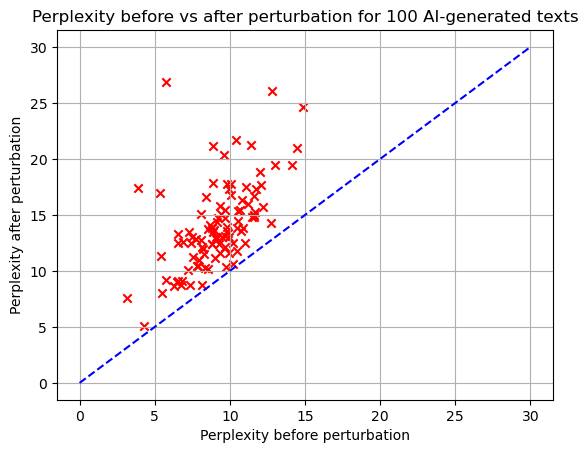

In [43]:
# Create scatter plot
plt.scatter(perplexities_before, perplexities_after,marker='x',c='r')

plt.xlabel("Perplexity before perturbation")
plt.ylabel("Perplexity after perturbation")
plt.plot([0,30],[0,30],'b--')
plt.title(f"Perplexity before vs after perturbation for {num_samples} AI-generated texts")
plt.grid(True)
plt.show()

Plot the change of perplexity after the perturbation. Do perturbation affect a lot thr results?
Goal: 